### CSV Export
This section exports the supernova fitting results to a CSV file for further analysis.

### Import libraries

In [ ]:
from pylab import *
import numpy as np
from matplotlib import rc
import os
from scipy.interpolate import interp1d
import pandas as pd  # For CSV export

# Specific libraries
import cosmolib as cs

# Visuals
rc('figure',figsize=(10,5))
rc('font',size=12)
rc('text',usetex=False)

### IMINUIT

In [19]:
# Load redshift data
redshifts = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-Redshifts.txt')

# Load template lightcurve
t_template, mag_template = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-SNI-Average_LightCurve.txt').T

# Intrinsic error parameter (magnitude)
sigma_int = 0.1  # Typical intrinsic scatter for SN Ia (can be adjusted)

class SNIaLightCurve:
    def __init__(self, template_data):
        self.template_t = template_data[0]
        self.template_mag = template_data[1]
        self.interpolator = interp1d(
            self.template_t,
            self.template_mag,
            kind='linear',
            fill_value='extrapolate',
            bounds_error=False
        )
        
    def __call__(self, t, pars):
        # pars : [t0, s, mu] where:
        # t0 : time of maximum brightness
        # s : stretch parameter (brighter-slower effect)
        # mu : distance modulus
        t0, s, mu = pars
        
        # Apply time stretch and shift
        t_stretched = (t - t0) / s
        
        # Interpolate template at stretched times using scipy interpolator
        mag_intrinsic = self.interpolator(t_stretched)
        
        # Apply brighter-slower correction: -1.52*(s-1) and add distance modulus
        mag_observed = mag_intrinsic - 1.52*(s-1) + mu
        
        return mag_observed

# Initialize template lightcurve
lc_template = SNIaLightCurve([t_template, mag_template])

# Arbitrary cosmological parameters to initialize mu_guess 
cosmo_pars = {'h': 0.7, 'omega_M_0': 0.3, 'omega_lambda_0': 0.7, 'w0': -1}

# Function to fit individual supernova
def fit_supernova_lightcurve(sn_number, redshift, lc_template, sigma_int, verbose=False):
    """
    Fit a single supernova lightcurve to extract distance modulus
    """
    # Load supernova data
    filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
    if not os.path.exists(filename):
        return None
        
    data = np.loadtxt(filename)
    t_obs = data[:, 0]  # observed time
    mag_obs = data[:, 1]  # observed magnitude
    mag_err = data[:, 2]  # magnitude errors
    
    # Add intrinsic error in quadrature
    total_mag_err = np.sqrt(mag_err**2 + sigma_int**2)
    
    # Convert to rest frame time
    t_rest = t_obs / (1 + redshift)
    
    # Initial guess: t0=0, s=1, mu=reasonable distance modulus for the redshift
    # Rough distance modulus estimate from redshift (assuming flat ΛCDM) (Omega_k = 0, according to our arbitrary cosmological parameters)
    mu_guess = cs.musn1a(redshift, cosmo_pars)
    # mu_guess = 35.0

    # Initial guess = [t0, s, mu]
    t0_guess = t_rest[np.argmin(mag_obs)]
    guess = np.array([t0_guess, 1.0, mu_guess])
    
    try:
        # Fit using Minuit with total error (including intrinsic scatter)
        result = cs.do_minuit(t_rest, mag_obs, total_mag_err, guess, 
                             functname=lc_template, verbose=verbose)
        
        fitm, fitted_values, errors, covariance, chi2, ndf = result
        
        return {
            'sn_number': sn_number,
            'redshift': redshift,
            't0': fitted_values[0],
            't0_err': errors[0],
            's': fitted_values[1],
            's_err': errors[1],
            'mu': fitted_values[2],
            'mu_err': errors[2],
            'chi2': chi2,
            'ndf': ndf,
            'chi2_reduced': chi2/ndf if ndf > 0 else np.inf,
            'sigma_int_used': sigma_int
        }
    except Exception as e:
        if verbose:
            print(f"Fitting failed for SN-{sn_number}: {e}")
        return None

# Fit all supernovae
print(f"Fitting individual supernova lightcurves with intrinsic error σ_int = {sigma_int:.3f} mag...")
fitting_results = []

for i in range(len(redshifts)):
    print(f"Fitting SN-{i}...")
    result = fit_supernova_lightcurve(i, redshifts[i], lc_template, sigma_int=sigma_int, verbose=True)
    if result is not None:
        fitting_results.append(result)
        print(f"SN-{i}: μ = {result['mu']:.3f} ± {result['mu_err']:.3f}, s = {result['s']:.3f} ± {result['s_err']:.3f}")
    print()

print(f"Successfully fitted {len(fitting_results)} supernovae")

# Display results
if fitting_results:
    print("\nFitting Results Summary:")
    print("SN\tRedshift\tμ ± σ_μ\t\ts ± σ_s\t\tχ²/ndf")
    print("-" * 70)
    for result in fitting_results:
        print(f"{result['sn_number']}\t{result['redshift']:.3f}\t\t{result['mu']:.3f} ± {result['mu_err']:.3f}\t{result['s']:.3f} ± {result['s_err']:.3f}\t{result['chi2_reduced']:.2f}")

    print(f"\nNote: All fits include intrinsic scatter σ_int = {sigma_int:.3f} mag")



Fitting individual supernova lightcurves with intrinsic error σ_int = 0.100 mag...
Fitting SN-0...
Fitting with Minuit
Chi2 = 14.632415587969982
ndf = 17
Fitted values:
[-0.2542516   1.04050709 43.65420524]
Errors:
[0.6284105  0.07409146 0.1346167 ]
Covariance:
[[ 0.39489975 -0.03545847 -0.05530375]
 [-0.03545847  0.00548954  0.00971009]
 [-0.05530375  0.00971009  0.01812166]]
SN-0: μ = 43.654 ± 0.135, s = 1.041 ± 0.074

Fitting SN-1...
Fitting with Minuit
Chi2 = 16.445185500737185
ndf = 17
Fitted values:
[ 3.14839241  0.93501919 41.93577425]
Errors:
[0.17706431 0.02447327 0.06845718]
Covariance:
[[0.03135177 0.00129676 0.00361793]
 [0.00129676 0.00059894 0.00157877]
 [0.00361793 0.00157877 0.00468638]]
SN-1: μ = 41.936 ± 0.068, s = 0.935 ± 0.024

Fitting SN-2...
Fitting with Minuit
Chi2 = 14.945948179444782
ndf = 17
Fitted values:
[-1.89054274  1.10804065 43.73460468]
Errors:
[0.28306963 0.05167101 0.10419365]
Covariance:
[[ 0.08012842 -0.00656963 -0.00918835]
 [-0.00656963  0.0026698

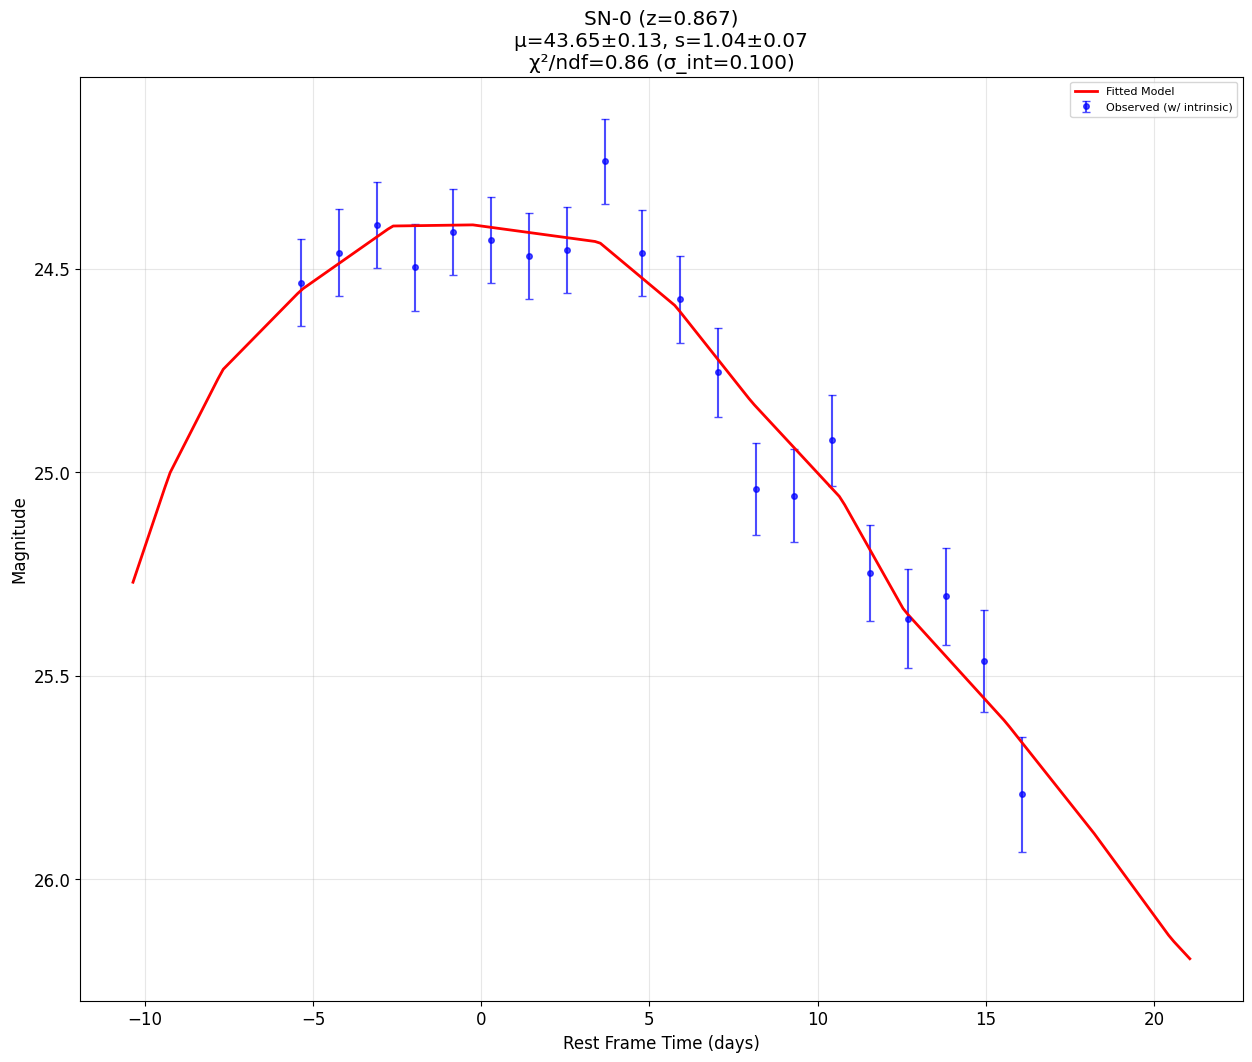

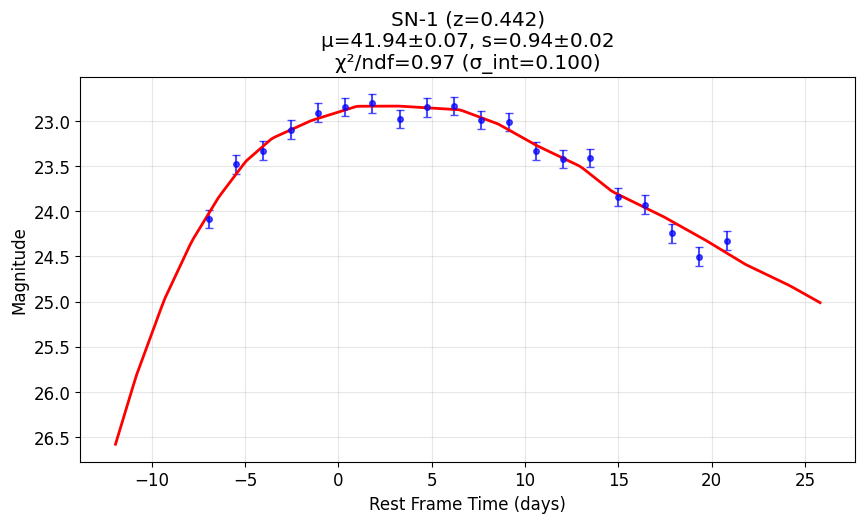


Displayed fitted lightcurves for the first 2 supernovae
Each plot shows:
- Blue points: Observed photometry with total error bars (observational + intrinsic)
- Red line: Best-fit template lightcurve
- Title includes redshift, fitted parameters (μ, s), χ²/ndf, and σ_int=0.100
- Total error = sqrt(observational_error² + 0.100²)


In [ ]:
# Plot fitted lightcurves for visualization
if fitting_results:
    # Select a subset of supernovae to plot (first 9 for a 3x3 grid)
    n_plot = min(2, len(fitting_results))
    
    figure(figsize=(15, 12))
    
    for i in range(n_plot):
        result = fitting_results[i]
        sn_number = result['sn_number']
        redshift = result['redshift']
        sigma_int_used = result.get('sigma_int_used', sigma_int)
        
        # Load observed data
        filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
        if os.path.exists(filename):
            data = np.loadtxt(filename)
            t_obs = data[:, 0]
            mag_obs = data[:, 1]
            mag_err = data[:, 2]
            
            # Calculate total error (including intrinsic scatter)
            total_mag_err = np.sqrt(mag_err**2 + sigma_int_used**2)
            
            # Convert to rest frame
            t_rest = t_obs / (1 + redshift)
            
            # Generate fitted lightcurve
            t_model = np.linspace(t_rest.min() - 5, t_rest.max() + 5, 200)
            fitted_pars = [result['t0'], result['s'], result['mu']]
            mag_model = lc_template(t_model, fitted_pars)
            
            # Plot in subplot
            
            
            # Plot observed data with total error bars
            errorbar(t_rest, mag_obs, yerr=total_mag_err, fmt='o', 
                    capsize=3, markersize=4, alpha=0.7, label='Observed (w/ intrinsic)', color='blue')
            
            # Plot fitted model
            plot(t_model, mag_model, 'r-', linewidth=2, label='Fitted Model')
            
            # Formatting with chi² value in title
            xlabel('Rest Frame Time (days)')
            ylabel('Magnitude')
            title(f'SN-{sn_number} (z={redshift:.3f})\nμ={result["mu"]:.2f}±{result["mu_err"]:.2f}, s={result["s"]:.2f}±{result["s_err"]:.2f}\nχ²/ndf={result["chi2_reduced"]:.2f} (σ_int={sigma_int_used:.3f})')
            grid(True, alpha=0.3)
            gca().invert_yaxis()  # Invert y-axis for magnitudes (brighter = lower values)
            
            if i == 0:  # Only show legend for first subplot
                legend(loc='upper right', fontsize=8)
            show()
    
    #tight_layout()
    #title('Fitted Supernova Lightcurves (First 9 SNe)', fontsize=16, y=0.98)
    #show()
    
    print(f"\nDisplayed fitted lightcurves for the first {n_plot} supernovae")
    print("Each plot shows:")
    print("- Blue points: Observed photometry with total error bars (observational + intrinsic)")
    print("- Red line: Best-fit template lightcurve")
    print(f"- Title includes redshift, fitted parameters (μ, s), χ²/ndf, and σ_int={sigma_int:.3f}")
    print(f"- Total error = sqrt(observational_error² + {sigma_int:.3f}²)")

In [ ]:
# Export results to CSV file
if fitting_results:
    # Convert results to DataFrame
    df_results = pd.DataFrame(fitting_results)
    
    # Reorder columns for better readability
    column_order = ['sn_number', 'redshift', 'mu', 'mu_err', 's', 's_err', 't0', 't0_err', 
                   'chi2', 'ndf', 'chi2_reduced', 'sigma_int_used']
    df_results = df_results[column_order]
    
    # Add some additional computed columns for analysis
    df_results['mu_significance'] = df_results['mu'] / df_results['mu_err']
    df_results['s_significance'] = abs(df_results['s'] - 1.0) / df_results['s_err']
    
    # Create output filename with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f'supernova_fitting_results_{timestamp}.csv'
    
    # Save to CSV
    df_results.to_csv(output_filename, index=False, float_format='%.6f')
    
    print(f"\n=== CSV Export Complete ===")
    print(f"Results saved to: {output_filename}")
    print(f"Number of supernovae: {len(df_results)}")
    print(f"Columns exported: {', '.join(df_results.columns)}")
    
    # Display basic statistics
    print(f"\n=== Summary Statistics ===")
    print(f"Distance modulus μ:")
    print(f"  Mean: {df_results['mu'].mean():.3f} ± {df_results['mu'].std():.3f}")
    print(f"  Range: [{df_results['mu'].min():.3f}, {df_results['mu'].max():.3f}]")
    print(f"Stretch parameter s:")
    print(f"  Mean: {df_results['s'].mean():.3f} ± {df_results['s'].std():.3f}")
    print(f"  Range: [{df_results['s'].min():.3f}, {df_results['s'].max():.3f}]")
    print(f"Reduced χ²:")
    print(f"  Mean: {df_results['chi2_reduced'].mean():.2f}")
    print(f"  Good fits (χ²/ndf < 2): {(df_results['chi2_reduced'] < 2).sum()}/{len(df_results)} ({100*(df_results['chi2_reduced'] < 2).mean():.1f}%)")
    
    # Display first few rows for verification
    print(f"\n=== First 5 rows of exported data ===")
    print(df_results.head().to_string(index=False, float_format=lambda x: f'{x:.4f}'))
else:
    print("No fitting results to export!")